<a href="https://colab.research.google.com/github/mgraci/NLP/blob/master/DistillBert_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook runs Distilbert Transfer Learning Model 

The source for sections of this code are from:
https://www.kaggle.com/maroberti/fastai-with-transformers-bert-roberta

General workflow for notebook:

1. Ingest Data
2. Clean Data
3. Tokenize Data
4. Contruct train / test splits
5. Configure model
6. Explore learning rates for model
7. Make first pass at training, assess results
8. Make second pass at training, assess results
9. Make a full pass on model, assess results
10. Export model for inference making


# Installing some relevant packages

In [ ]:
!pip install fastai==1.0.61
!pip install fastai transformers==2.8.0


# importing necessary packages 

In [ ]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)

fastai version : 1.0.61
transformers version : 2.8.0


In [ ]:
%reload_ext autoreload
%matplotlib inline


import os
import random
import numpy as np 
import pandas as pd
from sklearn.model_selection import train_test_split

# text packages 
import re
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk import word_tokenize
stopwords = list(set(stopwords.words('english')))

# torch
import torch
import torch.optim as optim

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# Connecting to google drive 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/My Drive/Coding_tutorials")
os.listdir()

['Transfer Learning for Text Classification Presentation.gslides',
 'clean_cp_complaints.csv',
 'Functional_movie_genre_DistillBert_all_labels.ipynb',
 'Functional_Customer_complaint_DistillBert.ipynb',
 'models',
 'model',
 'DistillBert_tutorial.ipynb']

# loading data and selecting text and label columns

- dataset source: https://www.kaggle.com/selener/consumer-complaint-database

In [ ]:
df = pd.read_csv('clean_cp_complaints.csv')
df.dropna(inplace=True) 
print(df.dtypes)

## map your text and target columns here
text_input = 'narrative'
target_label = 'label'

df_counts = df.groupby(target_label, as_index= False).count()
df_counts


label        object
narrative    object
dtype: object


,label,narrative
0,Bank account or service,636
1,Checking or savings account,955
2,Consumer Loan,461
3,Credit card,873
4,Credit card or prepaid card,1661
5,Credit reporting,1468
6,"Credit reporting, credit repair services, or o...",7369
7,Debt collection,5719
8,"Money transfer, virtual currency, or money ser...",383
9,Money transfers,64


In [ ]:
# the following labels occurred infrequency and will be removed as a result:
# - Other financial service	
# - Virtual currency

In [ ]:
too_few = ['Other financial service', 'Virtual currency']
df = df[~df['label'].isin(too_few)]
df.groupby(target_label, as_index= False).count()

,label,narrative
0,Bank account or service,636
1,Checking or savings account,955
2,Consumer Loan,461
3,Credit card,873
4,Credit card or prepaid card,1661
5,Credit reporting,1468
6,"Credit reporting, credit repair services, or o...",7369
7,Debt collection,5719
8,"Money transfer, virtual currency, or money ser...",383
9,Money transfers,64


# Cleaning text
- You don't need to clean much for transfer learning
  - Reason being, you want to give the model as much info as possible because you teaching a model to learn how to write the language that can then be leveraged in text classification
    - This is a key difference between word-embeddings and Transfer learning— Rather than identify a vector space for a sentence using high dimensional coordinates, transfer earning uses language models (LSTMs) that learn what's next, even learn how to write text itself. In a sense, the former attempts to build a thesaurusspy model that has a semantic understanding of language, and the latter attempts to build language model that has a world understanding of linguistic discourse.

In [ ]:
def preprocess_text(text, remove_stopwords = False):
    """
        text: a string

        args: remove_stopwords is set to False by default. 
              Switch to True if your heart desires 
        
        return: a cleaner string a text 
    """

    text = text.lower() # lowercase text
    text = text.replace('x', '') # replaces the xxx's that represented names
    text = ([word for word in word_tokenize(text.lower()) # removing symbols
              if str(word).isalpha()])
    if remove_stopwords:  # removing stopwords if stopwords set to True
        text = [word for word in text if word not in stopwords]

    text = ' '.join(word for word in text)
    return text


In [ ]:
df[text_input] = df[text_input].apply(preprocess_text)
df = df[[target_label, text_input]]
df = df.dropna()
df[target_label] =df[target_label].astype(str)

target_names = list(set(df[target_label]))

df.head()

,label,narrative
0,"Money transfer, virtual currency, or money ser...",met with personal banker a t wells fargo fl ph...
1,Credit reporting,my last name and my brother last is the same m...
2,"Credit reporting, credit repair services, or o...",unauthorized credit inquiries on credit report...
3,Debt collection,i requested a debt validation letter to valida...
4,"Credit reporting, credit repair services, or o...",submitted a dispute request concerning reasons...


# Selecting model

In [ ]:
# Parameters
## NOTE: lower bs if your kernel is crashing
seed = 42
use_fp16 = False
bs = 16


model_class, tokenizer_class, config_class = DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig

The keys below are for specific kinds of nlp tasks. For our text classification purposes, distilbert-base-uncased works well. 

In [ ]:
model_class.pretrained_model_archive_map.keys()

dict_keys(['distilbert-base-uncased', 'distilbert-base-uncased-distilled-squad', 'distilbert-base-cased', 'distilbert-base-cased-distilled-squad', 'distilbert-base-german-cased', 'distilbert-base-multilingual-cased', 'distilbert-base-uncased-finetuned-sst-2-english'])

In [ ]:
 pretrained_model_name = 'distilbert-base-uncased'

In [ ]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

seed_all(seed)

# Tokenizing text

In [ ]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens

In [ ]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})

In [ ]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])

In [ ]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)
tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)
transformer_processor = [tokenize_processor, numericalize_processor]

In [ ]:
pad_first = bool(model_type in ['distilbert'])
pad_idx = transformer_tokenizer.pad_token_id

In [ ]:
tokens = transformer_tokenizer.tokenize('The bank is giving me no flexibility in lowering my monthly payment rate for my mortage')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)

['the', 'bank', 'is', 'giving', 'me', 'no', 'flexibility', 'in', 'lowering', 'my', 'monthly', 'payment', 'rate', 'for', 'my', 'mort', '##age']
[1996, 2924, 2003, 3228, 2033, 2053, 16991, 1999, 13845, 2026, 7058, 7909, 3446, 2005, 2026, 22294, 4270]


['the',
 'bank',
 'is',
 'giving',
 'me',
 'no',
 'flexibility',
 'in',
 'lowering',
 'my',
 'monthly',
 'payment',
 'rate',
 'for',
 'my',
 'mort',
 '##age']

# constructing a FastAI friendly dataframe like object for model training

In [ ]:
databunch = (TextList.from_df(df, cols=text_input, processor=transformer_processor)
             .split_by_rand_pct(0.2,seed=seed)
             .label_from_df(cols= target_label)
            #  .add_test(test) # add this if / when you want a hold out set 
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

In [ ]:
databunch.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


text,target
[CLS] se ##lene finance llc too over my mortgage from as of i was approved by beginning for a loan modification and paid them every month until when se ##lene took over un ##bek ##now ##nst to me the modification was rejected to a incorrect paperwork filed by but they did not inform me that there was a problem did not fi the error with the paperwork nor with the,Mortgage
[CLS] i have been paying loans for na ##vie ##nt since for private loans taken out through them my payment allocation has never been clear and customer service representatives are poorly trained and can not give you clear answers i have been told many different things by different representatives my loan allocation ##s have gone towards interest payments for future months when i was ep ##ect ##ing them to go,Student loan
[CLS] i had a joint loan with ally financial my who was the joint sign ##er filed bankruptcy i had possession of the vehicle as awarded in the divorce decree due to his filing that i was unaware of my online access was blocked and no bills were sent to me electronically or by mail i contacted the comments as soon as i found i could not pay my bill,Vehicle loan or lease
[CLS] in my husband and i entered into an agreement with who later merged with century first credit solutions century first agreed to settle credit card accounts on our behalf we agreed to pay century first per month for months was automatically de ##ducted from our checking account at now we paid payments to century first in the amount of out of the accounts that were to be negotiated only,Debt collection
[CLS] our house was built and it is located in a town that has been entered onto the national register of historic places pursuant to the national historic preservation act of we purchased our house in and over our years of ownership our home has been completely renovated to ea ##cting standards consistent with the era i had ref ##ina ##nce ##d my home mortgage loan in with secure one,Mortgage


# configuring the model

In [ ]:
# defining our model architecture 
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits

In [ ]:
print(f' there are {len(target_names)} label targets found this data') 

 there are 16 label targets found this data


In [ ]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = len(target_names)
config.use_bfloat16 = use_fp16
print(config)

DistilBertConfig {
  "_num_labels": 16,
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "bad_words_ids": null,
  "bos_token_id": null,
  "decoder_start_token_id": null,
  "dim": 768,
  "do_sample": false,
  "dropout": 0.1,
  "early_stopping": false,
  "eos_token_id": null,
  "finetuning_task": null,
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3",
    "4": "LABEL_4",
    "5": "LABEL_5",
    "6": "LABEL_6",
    "7": "LABEL_7",
    "8": "LABEL_8",
    "9": "LABEL_9",
    "10": "LABEL_10",
    "11": "LABEL_11",
    "12": "LABEL_12",
    "13": "LABEL_13",
    "14": "LABEL_14",
    "15": "LABEL_15"
  },
  "initializer_range": 0.02,
  "is_decoder": false,
  "is_encoder_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_10": 10,
    "LABEL_11": 11,
    "LABEL_12": 12,
    "LABEL_13": 13,
    "LABEL_14": 14,
    "LABEL_15": 15,
    "LABEL

In [ ]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

# here you are setting up the model for learning

In [ ]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial


# Instantiate optimization function and callbacks
CustomAdamW = partial(AdamW, correct_bias = False)
f1 = FBeta(average = 'macro', beta = 1)



# Create learner
learner = Learner(
    data = databunch,
    model = custom_transformer_model,
    opt_func = CustomAdamW, 
    metrics = [accuracy, error_rate, f1]
    )

## Note: including early stopping would be a nice addition to the learner

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))
    
# Show model details.
print(learner.model)

CustomTransformerModel(
  (transformer): DistilBertForSequenceClassification(
    (distilbert): DistilBertModel(
      (embeddings): Embeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (transformer): Transformer(
        (layer): ModuleList(
          (0): TransformerBlock(
            (attention): MultiHeadSelfAttention(
              (dropout): Dropout(p=0.1, inplace=False)
              (q_lin): Linear(in_features=768, out_features=768, bias=True)
              (k_lin): Linear(in_features=768, out_features=768, bias=True)
              (v_lin): Linear(in_features=768, out_features=768, bias=True)
              (out_lin): Linear(in_features=768, out_features=768, bias=True)
            )
            (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
     

In [ ]:
list_layers = [learner.model.transformer.distilbert.embeddings,
               learner.model.transformer.distilbert.transformer.layer[0],
               learner.model.transformer.distilbert.transformer.layer[1],
               learner.model.transformer.distilbert.transformer.layer[2],
               learner.model.transformer.distilbert.transformer.layer[3],
               learner.model.transformer.distilbert.transformer.layer[4],
               learner.model.transformer.distilbert.transformer.layer[5],
               learner.model.transformer.pre_classifier]
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)


Learner split in 8 groups
[Sequential(
  (0): Embedding(30522, 768, padding_idx=0)
  (1): Embedding(512, 768)
  (2): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (3): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768, bias=True)
  (4): Linear(in_features=768, out_features=768, bias=True)
  (5): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=768, out_features=3072, bias=True)
  (8): Linear(in_features=3072, out_features=768, bias=True)
  (9): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
), Sequential(
  (0): Dropout(p=0.1, inplace=False)
  (1): Linear(in_features=768, out_features=768, bias=True)
  (2): Linear(in_features=768, out_features=768, bias=True)
  (3): Linear(in_features=768, out_features=768

# Model Building


## Begin the fine-tuning process by selecting the last layer group to tune

In [ ]:
learner.freeze_to(-1)

## Begin the fine-tuning process by selecting the last layer group to tune

Two things that can affect learning rates are:
1. your random seed
2. your view of the local minimum

Fastai has nice built-in process to find learning rates 

In [ ]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-03
Min loss divided by 10: 2.09E-04


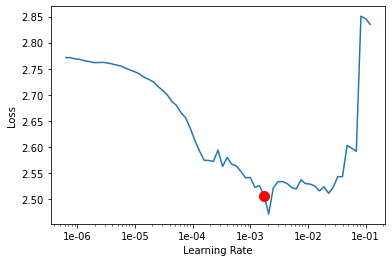

In [ ]:
learner.recorder.plot(skip_end = 10, suggestion=True)

Min numerical gradient: 9.12E-05
Min loss divided by 10: 3.31E-05


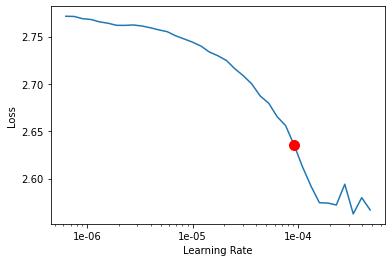

In [ ]:
learner.recorder.plot(skip_end=40,suggestion=True)

Couple Notes: 
- You can see how you might get a different learning rate depending on your snapshot of the learning rate

- We created a function to loop through learning rate suggestions to basically take the max voted learning rate. 

- An additional step we did with the practice is also loop through several random seeds of data to compile more votes in the learning rate selection.

In [ ]:

def find_appropriate_lr(model, lr_diff=15, loss_threshold=.05, adjust_value=1, plot=False):
    '''Find the "right" learning rate using an interval slide rule.

    This function was gotten from
    https://forums.fast.ai/t/automated-learning-rate-suggester/44199 with some
    slight modifications.
    '''
    # Run the Learning Rate Finder
    model.lr_find()

    # Plot the finder graph to force calculation of min_grad_lr
    min_grad_lrs = []
    for skip_end_val in range(0, 60, 10):
        model.recorder.plot(skip_end = skip_end_val, suggestion = True)

        try:
            lr_finder_suggestion = model.recorder.min_grad_lr
            min_grad_lrs.append(lr_finder_suggestion)
            if plot:
                plt.show()
        except:
            print('Failed to retrieve \'min_grad_lr\' from \'lr_find\'!')
        finally:
            plt.close()

    # Select FastAI LR based on majority vote. If there are
    # ties in values, choose the lowest LR of the tied values
    c = Counter(min_grad_lrs)
    equal_counts = 1
    max_count = float('-inf')
    min_lr = float('inf')
    for lr in c:
        if c[lr] > max_count:
            max_count = c[lr]
            equal_counts = 1
            min_lr = lr
        elif c[lr] == max_count:
            equal_counts += 1

            if lr < min_lr:
                min_lr = lr

    if equal_counts == len(c) or equal_counts > 1:
        # Either there was no majority (all 1's count) or
        # there were some values that had the same high
        # count (e.g., 2 counts of 2e-1 and 2 counts of 3e-1)
        # so choose the lowest LR of the tied values (2e-1).
        lr_finder_suggestion = min_lr
    else:
        lr_finder_suggestion = c.most_common(1)[0][0]

    # Get loss values and their corresponding gradients, and get lr values
    losses = np.array(model.recorder.losses)
    if lr_diff >= len(losses):
        print(
            '\'lr_diff\' is larger than the length of loss values!'
            f' Setting current \'lr_diff\' to half of length: {int(len(losses)/2)}...'
        )
        lr_diff = int(len(losses)/2)
    loss_grad = np.gradient(losses)
    lrs = model.recorder.lrs

    # Search for index in gradients where loss is lowest before the loss spike.
    # Initialize right and left idx using the lr_diff as a spacing unit.
    r_idx = -1
    l_idx = r_idx - lr_diff
    local_min_lr = lrs[l_idx]
    while (l_idx >= -len(losses)) and (abs(loss_grad[r_idx] - loss_grad[l_idx]) > loss_threshold):
        r_idx -= 1
        l_idx -= 1
        try:
            local_min_lr = lrs[l_idx]
        except:
            l_idx += 1
            break

    lr_to_use = local_min_lr * adjust_value

    if plot:
        # Plots the gradients of the losses w/respect to learning rate changes
        plt.plot(loss_grad)
        plt.plot(
            len(losses) + l_idx,
            loss_grad[l_idx],
            markersize = 10,
            marker = 'o',
            color = 'red'
        )
        plt.ylabel('Loss Gradient')
        plt.xlabel('Index of LRs')
        plt.show()

        plt.plot(np.log10(lrs), losses)
        plt.ylabel('Loss')
        plt.xlabel('Log 10 Transform of Learning Rate')
        loss_coord = np.interp(np.log10(lr_to_use), np.log10(lrs), losses)
        plt.plot(
            np.log10(lr_to_use),
            loss_coord,
            markersize = 10,
            marker = 'o',
            color = 'red'
        )
        plt.show()

    return lr_to_use, lr_finder_suggestion

For the sake of simplicity, feel free to go with the fastai_suggested_lr for model training 

epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 5.25E-01
Min loss divided by 10: 7.59E-04


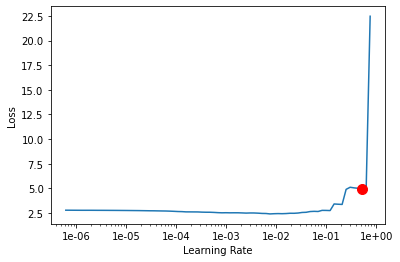

Min numerical gradient: 6.31E-03
Min loss divided by 10: 7.59E-04


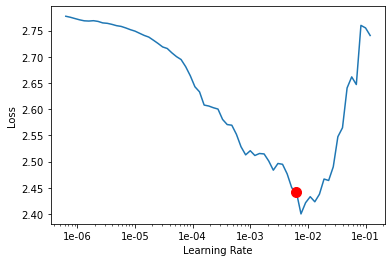

Min numerical gradient: 6.31E-03
Min loss divided by 10: 7.59E-04


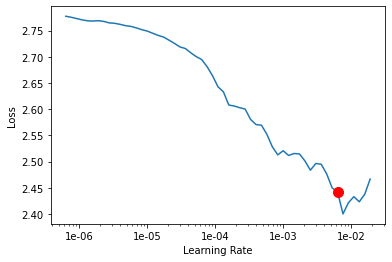

Min numerical gradient: 5.75E-04
Min loss divided by 10: 2.51E-04


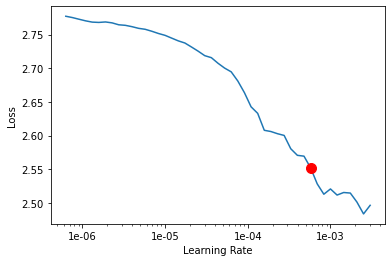

Min numerical gradient: 9.12E-05
Min loss divided by 10: 4.79E-05


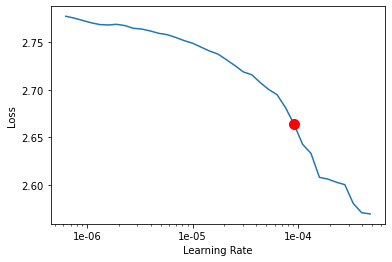

Min numerical gradient: 7.59E-05
Min loss divided by 10: 7.59E-06


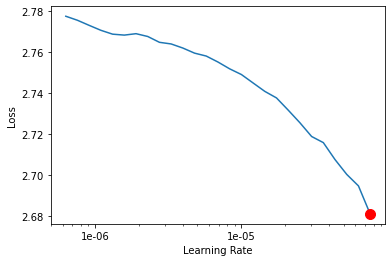

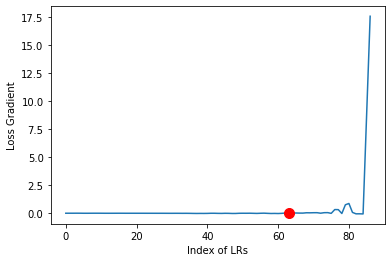

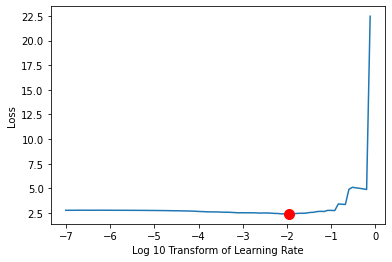

In [ ]:
suggested_lr, fastai_suggested_lr = find_appropriate_lr(
                            learner, 
                            lr_diff = 15,
                            plot = True
                        )

In [ ]:
print(suggested_lr, fastai_suggested_lr)

0.01096478196143185 0.006309573444801929


## More about learning rates in fastAI

- adjust the learning rate in learner.fit_one_cycle to the optimal learning rate found with the lr_find().

- After using the find_appropriate_lr function, it will be the most popular 'Min numerical gradient' level learning

- num_cycles basically = epochs. 

- NOTE: if the error_rate looks way off during fit_one_cycle, the learner rate it off 

- For training, info on using .fit_one_cycle: 
https://docs.fast.ai/callbacks.one_cycle.html

In [ ]:
# how many times want train the train 
epochs = 10

print(f'currently set for {epochs} cycles of training')

currently set for 10 cycles of training


epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,time
0,1.459777,1.567162,0.524518,0.475482,0.156502,02:52
1,1.564547,1.398533,0.557878,0.442122,0.231392,03:00
2,1.494882,1.477065,0.523312,0.476688,0.209588,02:43
3,1.409485,1.368200,0.566318,0.433682,0.256840,02:21
4,1.319286,1.362133,0.518891,0.481109,0.229097,02:33
5,1.344240,1.240704,0.598272,0.401728,0.276315,02:39
6,1.272131,1.228589,0.597267,0.402733,0.279141,02:31
7,1.210167,1.133625,0.630426,0.369574,0.306197,02:27
8,1.186586,1.115514,0.638264,0.361736,0.307577,02:56
9,1.153207,1.111184,0.639871,0.360129,0.309315,02:27


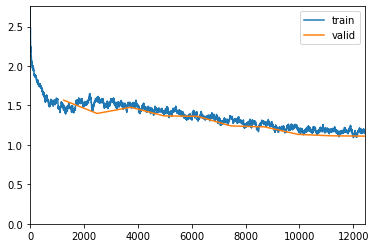

In [ ]:
learner.fit_one_cycle( epochs, fastai_suggested_lr, moms=(0.8,0.7))

In [ ]:
# when experimenting in an environment, 
# you'll want to save out the model parameters to keep your progress

# when you're ready to productionalize or move the model to another
# environment or notebook, use learner.export() and load it back up with joblib

learner.save('temp_model1')
learner.load('temp_model1')
print('saved and loaded')

saved and loaded


In [ ]:
example1 = learner.predict("These student loans rates are really hurting" )
# making a class label index
class_index = inv_map = {v: k for k, v in learner.data.c2i.items()}
class_index.get(int(example1[1]))


'Student loan'

In [ ]:
example2 = learner.predict("The car company won't stop calling me")
class_index.get(int(example2[1]))

'Debt collection'

# Setting up predictions and confusion matrix 

In [ ]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)

/usr/local/lib/python3.6/dist-packages/fastai/train.py:213: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


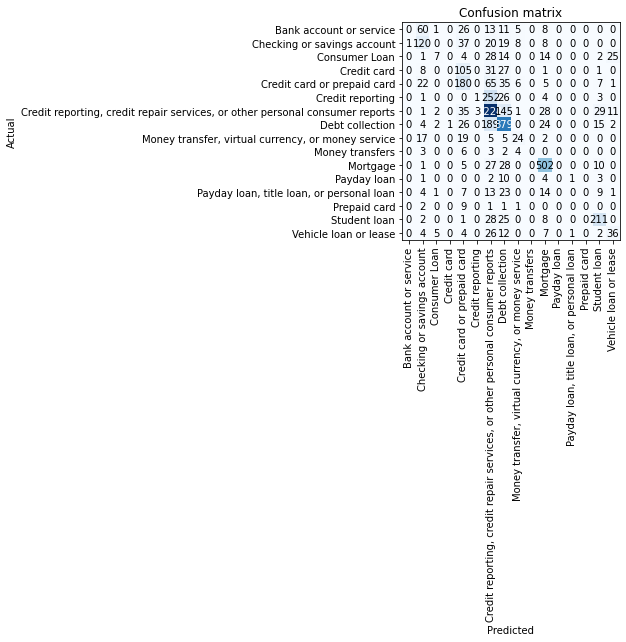

In [ ]:
interp.plot_confusion_matrix()

# Additional Feature Engineering 
-  For further improvements in the model, you can start to train the second to last layer like below 
  -  You can keep going back layers and layers, but the more you do that the more you diminish the purpose of transfer learning by readjusting all the weights a lot and run the risk of an overgeneralize model. 

In [ ]:
learner.freeze_to(-2)


You'll want to try to find the learning rate again. One extra caveat here is that you're going to want to slow down the learning. You can slow down the learning rate by using the suggested learning rate then dividing it by particular number - the number we found on fastai  = /(2.6**4)

epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


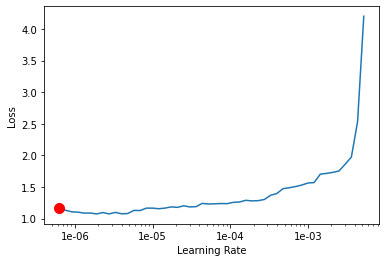

Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


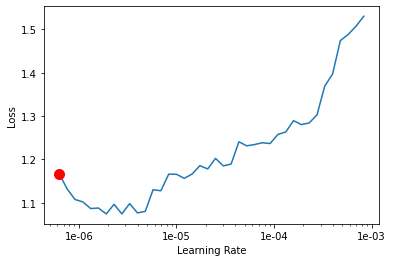

Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


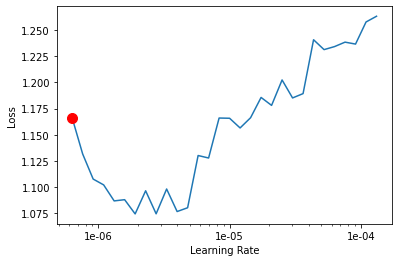

Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


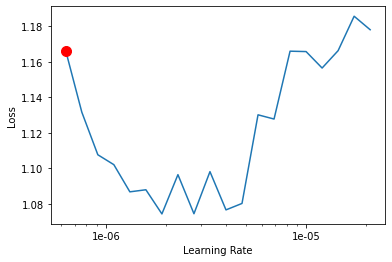

Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.91E-07


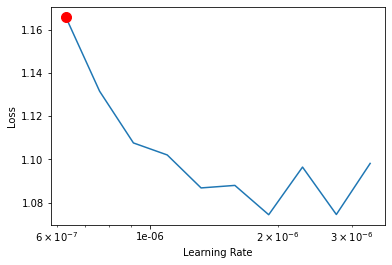

Failed to compute the gradients, there might not be enough points.


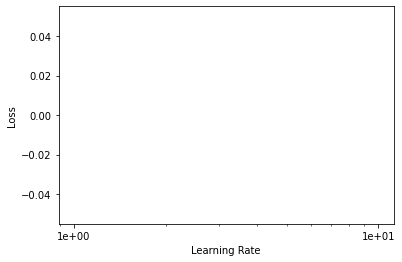

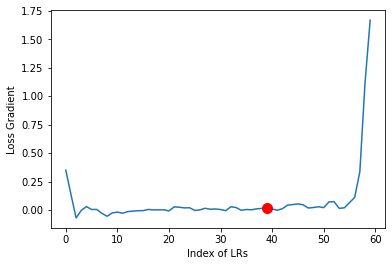

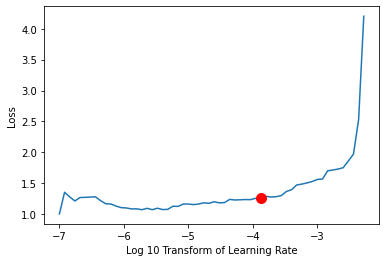

In [ ]:
suggested_lr, fastai_suggested_lr = find_appropriate_lr(
                            learner, 
                            lr_diff = 15,
                            plot = True
                        )


In [ ]:
epochs = 3 

epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,time
0,1.159045,1.103079,0.642283,0.357717,0.311377,02:59
1,1.152228,1.094126,0.643489,0.356511,0.313013,03:08
2,1.150449,1.093117,0.644695,0.355305,0.314907,03:23


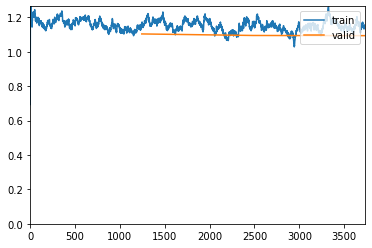

In [ ]:
learner.fit_one_cycle(epochs, slice(fastai_suggested_lr/(2.6**4), fastai_suggested_lr), moms=(0.8,0.7))

In [ ]:
learner.save('temp_model2')
learner.load('temp_model2')
print('saved and loaded')

saved and loaded


In [ ]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)

/usr/local/lib/python3.6/dist-packages/fastai/train.py:213: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


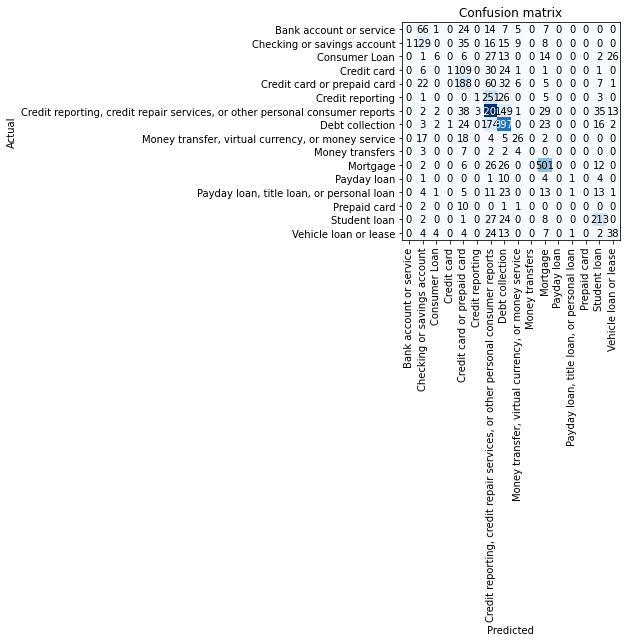

In [ ]:
interp.plot_confusion_matrix()

learner.unfreeze() unfreezing all of the layers. We've seen the unfreeze done at the end to align primary fine-tunin to the model. Again, just be mindful of how many times you run a completely unfrozen model. 

epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


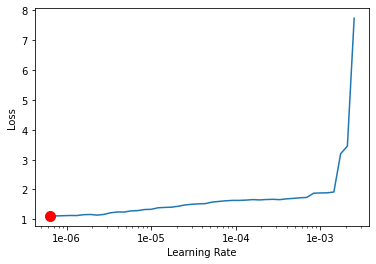

Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


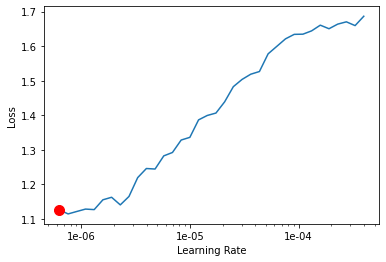

Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


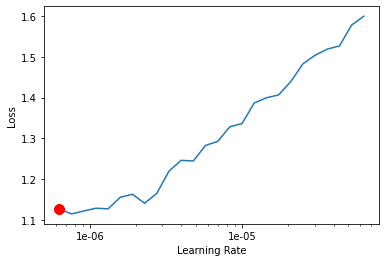

Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


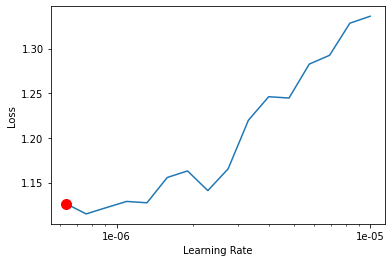

Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


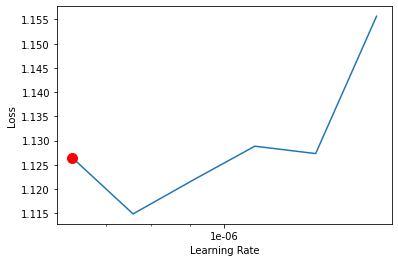

Failed to compute the gradients, there might not be enough points.


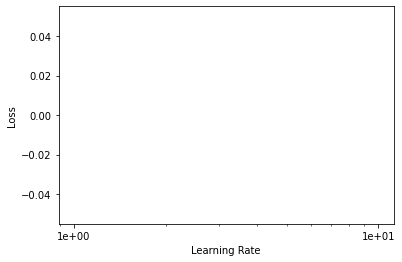

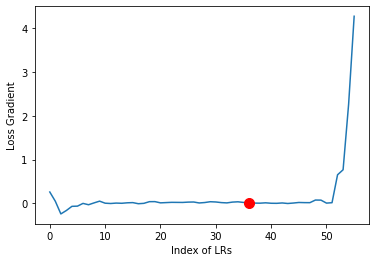

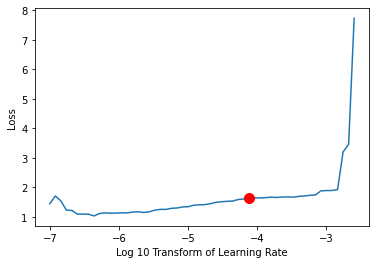

In [ ]:
learner.unfreeze()


suggested_lr, fastai_suggested_lr = find_appropriate_lr(
                            learner, 
                            lr_diff = 15,
                            plot = True
                        )


epoch,train_loss,valid_loss,accuracy,error_rate,f_beta,time
0,1.111787,1.065585,0.653939,0.346061,0.322286,07:24


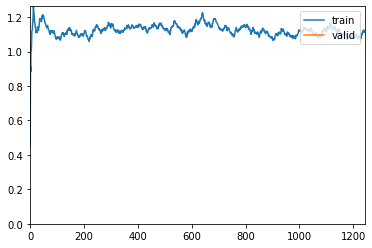

In [ ]:
learner.fit_one_cycle(1, slice(fastai_suggested_lr/(2.6**4), fastai_suggested_lr), moms=(0.8,0.7))

In [ ]:
learner.save('temp_model3')
learner.load('temp_model3')
print('saved and loaded')

saved and loaded


In [ ]:
preds,y,losses = learner.get_preds(with_loss=True)
interp = ClassificationInterpretation(learner, preds, y, losses)

/usr/local/lib/python3.6/dist-packages/fastai/train.py:213: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  plt.tight_layout()


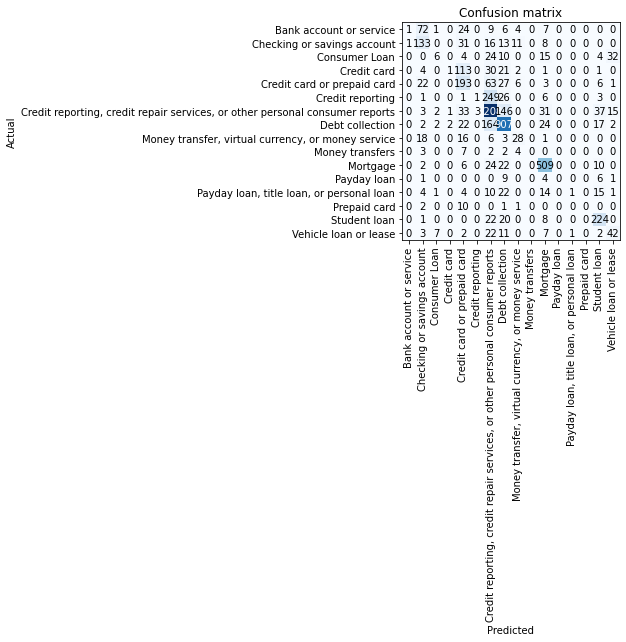

In [ ]:
interp.plot_confusion_matrix()

In [ ]:
# learner.export('final_model') # this saves out the model for later inference making

In [ ]:
### End of notebook ###